# Feature Selection Methods for High-Dimensional Data

In this notebook, we demonstrate practical implementation of three popular feature selection methods:
- Symmetrical Uncertainty (SU) filter
- Minimum Redundancy Maximum Relevance (mRMR)
- Embedded method: ElasticNet

We use synthetic high-dimensional data with 100 features to illustrate the process.


In [18]:
# Step 1: Import required libraries and prepare data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.feature_selection import mutual_info_classif, SelectFromModel
from sklearn.linear_model import ElasticNetCV

sns.set(style='whitegrid')


X, y = make_classification(
    n_samples=50,
    n_features=10,     
    n_informative=5,
    n_redundant=2,
    random_state=42
)

df = pd.DataFrame(X, columns=[f"F{i}" for i in range(X.shape[1])])
df['target'] = y

print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (50, 11)


,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,target
0,1.311581,-1.125577,-0.844137,0.992452,0.920227,2.384851,0.748901,1.212385,-0.343201,0.457676,0
1,2.211926,-0.345628,-0.431942,2.332600,0.197755,2.330202,3.368887,2.556955,1.859967,1.200412,0
2,2.948210,-0.143628,-0.313024,-2.973841,1.937705,4.465270,-0.421532,2.515299,-1.599123,-1.368590,1
3,-0.503354,-0.395556,0.042134,1.980834,-2.920828,-0.518497,3.126784,1.345362,0.514589,1.204635,0
4,-1.617714,0.312567,0.169973,-2.088481,-0.390938,-1.258157,-2.042146,-1.286799,1.153245,1.026580,1


## Step 2: Compute Symmetrical Uncertainty (SU) scores

We approximate SU using normalized mutual information between each feature and the target.


Selected by SU filter: 1 features


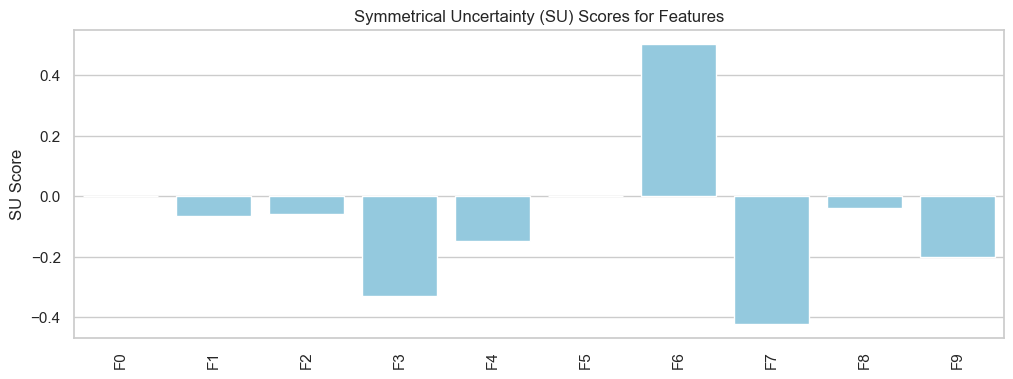

In [19]:
mi_scores = mutual_info_classif(X, y, random_state=0)

var_X = np.var(X, axis=0) + 1e-9
var_y = np.var(y) + 1e-9
su_scores = 2 * mi_scores / (np.log2(var_X) + np.log2(var_y))

threshold = np.quantile(su_scores, 0.90)
su_selected = np.where(su_scores >= threshold)[0]
print(f"Selected by SU filter: {len(su_selected)} features")

plt.figure(figsize=(12,4))
sns.barplot(x=[f"F{i}" for i in range(len(su_scores))], y=su_scores, color='skyblue')
plt.xticks(rotation=90)
plt.title('Symmetrical Uncertainty (SU) Scores for Features')
plt.ylabel('SU Score')
plt.show()


## Step 3: Apply mRMR (Minimum Redundancy Maximum Relevance)

mRMR selects features highly correlated with the target, but minimally redundant with each other.


In [20]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

def mrmr_select(X, y, k=10):
    mi = mutual_info_classif(X, y, random_state=0)  
    selected = [np.argmax(mi)]  
    
    for _ in range(1, k):
        scores = []
        for j in range(X.shape[1]):
            if j in selected:
                continue
            
            redundancy = np.mean([mutual_info_regression(X[:,[j]], X[:,[s]].ravel())[0] for s in selected])
            score = mi[j] - redundancy
            scores.append((score, j))
        
        selected.append(max(scores)[1])
    return selected

mrmr_selected = mrmr_select(X, y, k=10)
print(f"Selected by mRMR: {mrmr_selected}")


Selected by mRMR: [np.int64(9), 3, 2, 7, 8, 6, 4, 0, 1, 5]


## Step 4: Use Embedded Method (ElasticNet)

ElasticNet combines L1 and L2 penalties, selecting features with non-zero coefficients.


Selected by ElasticNet: 6 features


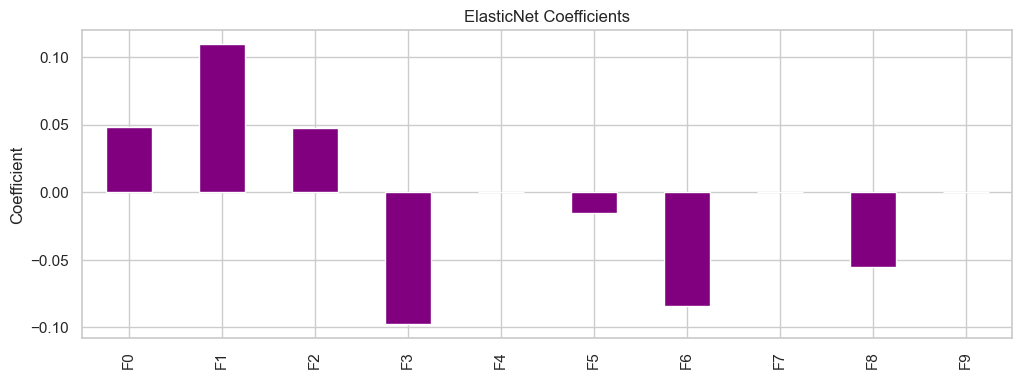

In [21]:
enet = ElasticNetCV(l1_ratio=0.9, cv=5, random_state=0).fit(X, y)

model = SelectFromModel(enet, prefit=True, threshold='mean')
enet_selected = model.get_support(indices=True)

print(f"Selected by ElasticNet: {len(enet_selected)} features")

# Plot coefficients
coef = pd.Series(enet.coef_, index=[f"F{i}" for i in range(X.shape[1])])
plt.figure(figsize=(12,4))
coef.plot(kind='bar', color='purple')
plt.title('ElasticNet Coefficients')
plt.ylabel('Coefficient')
plt.show()


## Step 5: Visualize and compare selected features


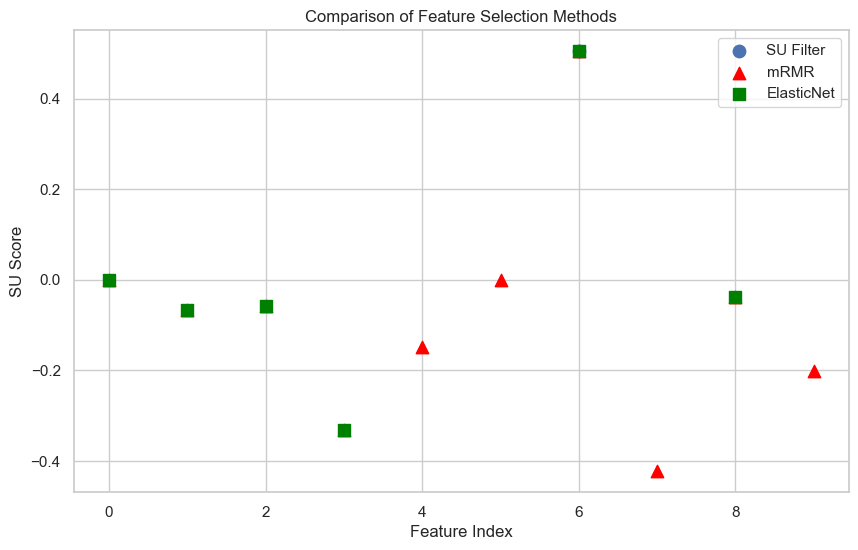

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(su_selected, su_scores[su_selected], label="SU Filter", s=80, marker='o')
plt.scatter(mrmr_selected, su_scores[mrmr_selected], label="mRMR", s=80, marker='^', color='red')
plt.scatter(enet_selected, su_scores[enet_selected], label="ElasticNet", s=80, marker='s', color='green')

plt.xlabel("Feature Index")
plt.ylabel("SU Score")
plt.title("Comparison of Feature Selection Methods")
plt.legend()
plt.show()


## Step 6: Correlation heatmap of SU-selected features


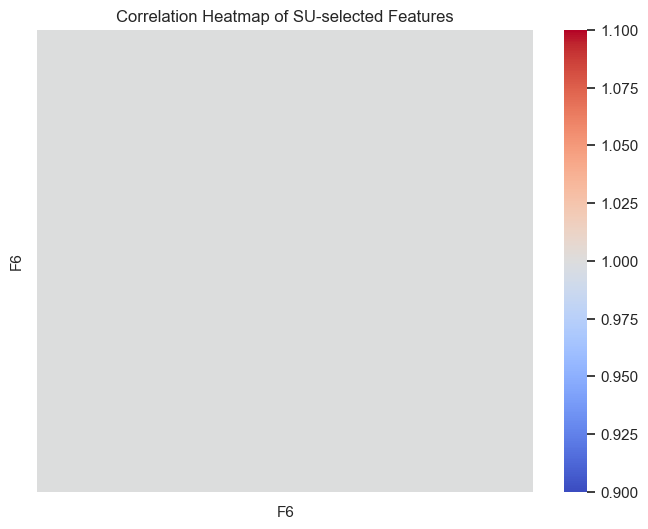

In [23]:
selected_df = df.iloc[:, su_selected]

plt.figure(figsize=(8,6))
sns.heatmap(selected_df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of SU-selected Features')
plt.show()
